## Churn Prediction for a Video Streaming Service

This project tackles a real-world machine learning problem: **predicting customer churn** for a video streaming subscription service. The goal is to build a classification model that estimates the **probability** a customer will cancel their subscription in the near future.

Churn prediction is a critical use case for subscription-based businesses, enabling targeted retention strategies and efficient customer engagement. Reasons for churn may include:
- Completion of available content
- Changes in user availability or interest
- Dissatisfaction with the service or platform

### The Challenge

You are tasked with building a machine learning model that predicts the likelihood of churn using anonymized customer data collected prior to cancellation events. The available dataset includes:
- A **training set**: customer features and a binary `Churn` label (1 = churned, 0 = retained)
- A **test set**: only customer features are provided — the true churn outcomes are withheld

The objective is to **train a well-calibrated model** and output a set of predictions (as probabilities) for the test set. These predictions are then evaluated against hidden ground-truth labels using **ROC-AUC**, a metric that balances ranking quality with probabilistic accuracy.

### Deliverables

- A model trained on labeled customer subscription data
- A prediction file with:
  - `CustomerID`: unique identifier
  - `predicted_probability`: probability of churn
- Evaluation metrics: precision, recall, F1, ROC-AUC, log loss

This project demonstrates practical skills in:
- Data preprocessing and feature engineering
- Classification model selection and tuning
- Probability-based evaluation and business-aligned metrics

> Note: This project was developed using data and challenge structure provided by a Coursera capstone course. The dataset is not included here.

In [1]:
import pandas as pd
data_descriptions = pd.read_csv('../data/data_descriptions.csv')
pd.set_option('display.max_colwidth', None)
data_descriptions

,Column_name,Column_type,Data_type,Description
0,AccountAge,Feature,integer,The age of the user's account in months.
1,MonthlyCharges,Feature,float,The amount charged to the user on a monthly basis.
2,TotalCharges,Feature,float,The total charges incurred by the user over the account's lifetime.
3,SubscriptionType,Feature,object,"The type of subscription chosen by the user (Basic, Standard, or Premium)."
4,PaymentMethod,Feature,string,The method of payment used by the user.
5,PaperlessBilling,Feature,string,Indicates whether the user has opted for paperless billing (Yes or No).
6,ContentType,Feature,string,"The type of content preferred by the user (Movies, TV Shows, or Both)."
7,MultiDeviceAccess,Feature,string,Indicates whether the user has access to the service on multiple devices (Yes or No).
8,DeviceRegistered,Feature,string,"The type of device registered by the user (TV, Mobile, Tablet, or Computer)."
9,ViewingHoursPerWeek,Feature,float,The number of hours the user spends watching content per week.


## Core libraries and tools 

In [56]:
# Imports

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Modeling and Evaluation
from sklearn.model_selection import (
    train_test_split, GridSearchCV,
    StratifiedKFold, cross_val_score, cross_val_predict
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, log_loss, roc_auc_score, classification_report,
    precision_score, recall_score, f1_score,
    precision_recall_curve, roc_curve
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Advanced Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Imbalanced data handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Explainability (SHAP)
import shap

# Statistical tools
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# AutoML / Optimization
import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, FloatDistribution, CategoricalDistribution
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Turn off warnings
import warnings
warnings.filterwarnings("ignore")

## Loading the Data

In [3]:
train_df = pd.read_csv("../data/train.csv")
print('train_df Shape:', train_df.shape)
train_df.head()

train_df Shape: (243787, 21)


,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,...,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,CustomerID,Churn
0,20,11.055215,221.104302,Premium,Mailed check,No,Both,No,Mobile,36.758104,...,10,Sci-Fi,2.176498,4,Male,3,No,No,CB6SXPNVZA,0
1,57,5.175208,294.986882,Basic,Credit card,Yes,Movies,No,Tablet,32.450568,...,18,Action,3.478632,8,Male,23,No,Yes,S7R2G87O09,0
2,73,12.106657,883.785952,Basic,Mailed check,Yes,Movies,No,Computer,7.395160,...,23,Fantasy,4.238824,6,Male,1,Yes,Yes,EASDC20BDT,0
3,32,7.263743,232.439774,Basic,Electronic check,No,TV Shows,No,Tablet,27.960389,...,30,Drama,4.276013,2,Male,24,Yes,Yes,NPF69NT69N,0
4,57,16.953078,966.325422,Premium,Electronic check,Yes,TV Shows,No,TV,20.083397,...,20,Comedy,3.616170,4,Female,0,No,No,4LGYPK7VOL,0


In [4]:
test_df = pd.read_csv("../data/test.csv")
print('test_df Shape:', test_df.shape)
test_df.head()

test_df Shape: (104480, 20)


,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,CustomerID
0,38,17.869374,679.036195,Premium,Mailed check,No,TV Shows,No,TV,29.126308,122.274031,42,Comedy,3.522724,2,Male,23,No,No,O1W6BHP6RM
1,77,9.912854,763.289768,Basic,Electronic check,Yes,TV Shows,No,TV,36.873729,57.093319,43,Action,2.021545,2,Female,22,Yes,No,LFR4X92X8H
2,5,15.019011,75.095057,Standard,Bank transfer,No,TV Shows,Yes,Computer,7.601729,140.414001,14,Sci-Fi,4.806126,2,Female,22,No,Yes,QM5GBIYODA
3,88,15.357406,1351.451692,Standard,Electronic check,No,Both,Yes,Tablet,35.586430,177.002419,14,Comedy,4.943900,0,Female,23,Yes,Yes,D9RXTK2K9F
4,91,12.406033,1128.949004,Standard,Credit card,Yes,TV Shows,Yes,Tablet,23.503651,70.308376,6,Drama,2.846880,6,Female,0,No,No,ENTCCHR1LR


## Exploratory Data Analysis (EDA) 

#### 1. Training data

In [5]:
# Overall view
print("Training Data Info:")
print(train_df.info())
print(55*'-')
print("Unique values:")
print(train_df.nunique())

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243787 entries, 0 to 243786
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   AccountAge                243787 non-null  int64  
 1   MonthlyCharges            243787 non-null  float64
 2   TotalCharges              243787 non-null  float64
 3   SubscriptionType          243787 non-null  object 
 4   PaymentMethod             243787 non-null  object 
 5   PaperlessBilling          243787 non-null  object 
 6   ContentType               243787 non-null  object 
 7   MultiDeviceAccess         243787 non-null  object 
 8   DeviceRegistered          243787 non-null  object 
 9   ViewingHoursPerWeek       243787 non-null  float64
 10  AverageViewingDuration    243787 non-null  float64
 11  ContentDownloadsPerMonth  243787 non-null  int64  
 12  GenrePreference           243787 non-null  object 
 13  UserRating              

In [6]:
# Let's see the statistics
train_df.describe()

,AccountAge,MonthlyCharges,TotalCharges,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,UserRating,SupportTicketsPerMonth,WatchlistSize,Churn
count,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000
mean,60.083758,12.490695,750.741017,20.502179,92.264061,24.503513,3.002713,4.504186,12.018508,0.181232
std,34.285143,4.327615,523.073273,11.243753,50.505243,14.421174,1.155259,2.872548,7.193034,0.385211
min,1.000000,4.990062,4.991154,1.000065,5.000547,0.000000,1.000007,0.000000,0.000000,0.000000
25%,30.000000,8.738543,329.147027,10.763953,48.382395,12.000000,2.000853,2.000000,6.000000,0.000000
50%,60.000000,12.495555,649.878487,20.523116,92.249992,24.000000,3.002261,4.000000,12.000000,0.000000
75%,90.000000,16.238160,1089.317362,30.219396,135.908048,37.000000,4.002157,7.000000,18.000000,0.000000
max,119.000000,19.989957,2378.723844,39.999723,179.999275,49.000000,4.999989,9.000000,24.000000,1.000000


In [7]:
# Missing Values - to be sure
train_df.isnull().sum()      

AccountAge                  0
MonthlyCharges              0
TotalCharges                0
SubscriptionType            0
PaymentMethod               0
PaperlessBilling            0
ContentType                 0
MultiDeviceAccess           0
DeviceRegistered            0
ViewingHoursPerWeek         0
AverageViewingDuration      0
ContentDownloadsPerMonth    0
GenrePreference             0
UserRating                  0
SupportTicketsPerMonth      0
Gender                      0
WatchlistSize               0
ParentalControl             0
SubtitlesEnabled            0
CustomerID                  0
Churn                       0
dtype: int64

In [8]:
# Duplicates
train_df.duplicated().sum()

0

In [9]:
# Selecting the numerical columns
num_cols = ['AccountAge', 'MonthlyCharges', 'TotalCharges', 'ViewingHoursPerWeek', 'AverageViewingDuration', 'ContentDownloadsPerMonth', 
            'UserRating', 'SupportTicketsPerMonth', 'WatchlistSize']
print(train_df[num_cols].dtypes) 

AccountAge                    int64
MonthlyCharges              float64
TotalCharges                float64
ViewingHoursPerWeek         float64
AverageViewingDuration      float64
ContentDownloadsPerMonth      int64
UserRating                  float64
SupportTicketsPerMonth        int64
WatchlistSize                 int64
dtype: object


In [10]:
# Outliers
Q1 = train_df[num_cols].quantile(0.25)
Q3 = train_df[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = (train_df[num_cols] < (Q1 - 1.5 * IQR)) | (train_df[num_cols] > (Q3 + 1.5 * IQR))
outliers
outlier_number = outliers.sum()
outlier_ratio =  outliers.sum() / 243787 * 100
outlier_number, outlier_ratio

(AccountAge                    0
 MonthlyCharges                0
 TotalCharges                741
 ViewingHoursPerWeek           0
 AverageViewingDuration        0
 ContentDownloadsPerMonth      0
 UserRating                    0
 SupportTicketsPerMonth        0
 WatchlistSize                 0
 dtype: int64,
 AccountAge                  0.000000
 MonthlyCharges              0.000000
 TotalCharges                0.303954
 ViewingHoursPerWeek         0.000000
 AverageViewingDuration      0.000000
 ContentDownloadsPerMonth    0.000000
 UserRating                  0.000000
 SupportTicketsPerMonth      0.000000
 WatchlistSize               0.000000
 dtype: float64)

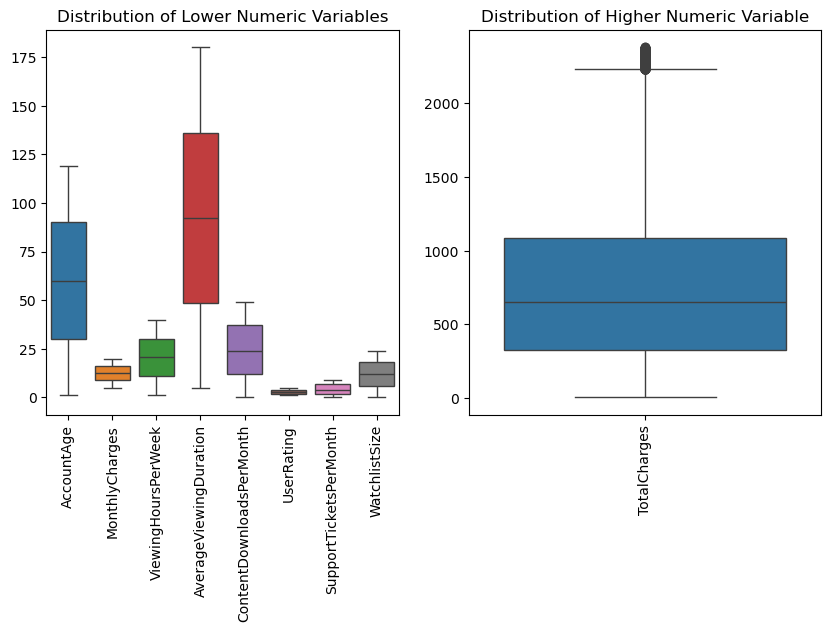

In [11]:
# Let's see the outliers
fig, axes = plt.subplots(1, 2, figsize=(10,5))

data = train_df[['AccountAge', 'MonthlyCharges', 'ViewingHoursPerWeek', 'AverageViewingDuration', 'ContentDownloadsPerMonth', 'UserRating', 'SupportTicketsPerMonth',  'WatchlistSize']] 
data1 = train_df[['TotalCharges']]
sns.boxplot(data=data, ax=axes[0])
axes[0].set_title("Distribution of Lower Numeric Variables")
axes[0].tick_params(axis='x', rotation=90)

sns.boxplot(data=data1, ax=axes[1])
axes[1].set_title("Distribution of Higher Numeric Variable")
axes[1].tick_params(axis='x', rotation=90)
plt.show()

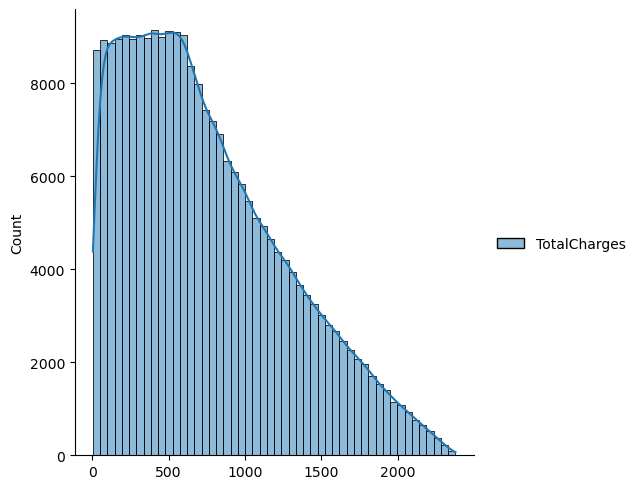

In [12]:
# More closely
sns.displot(data1, bins=50, kde=True)
plt.show()

In [13]:
# Target variable balance
churn_counts = train_df['Churn'].value_counts()
imbalance_ratio = churn_counts[0] / churn_counts[1]
print(churn_counts)
print(30*'-')
print('Imbalance ratio:', imbalance_ratio)

Churn
0    199605
1     44182
Name: count, dtype: int64
------------------------------
Imbalance ratio: 4.517790050246707


In [14]:
# Correlation check
num_cols_corr = num_cols + ['Churn']

corr_matrix1 = train_df[num_cols_corr].corr()
corr_matrix1

,AccountAge,MonthlyCharges,TotalCharges,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,UserRating,SupportTicketsPerMonth,WatchlistSize,Churn
AccountAge,1.000000,0.001706,0.820144,-0.001640,0.000191,0.001220,0.000440,-0.002055,-0.002640,-0.197736
MonthlyCharges,0.001706,1.000000,0.498207,-0.003029,-0.000604,-0.000127,0.000056,0.000071,-0.000540,0.100473
TotalCharges,0.820144,0.498207,1.000000,-0.003006,0.000860,0.000208,0.000609,-0.001770,-0.001770,-0.120529
ViewingHoursPerWeek,-0.001640,-0.003029,-0.003006,1.000000,0.000949,0.002149,-0.003185,0.000788,-0.000750,-0.128645
AverageViewingDuration,0.000191,-0.000604,0.000860,0.000949,1.000000,-0.002397,-0.000406,-0.000158,0.000749,-0.146897
ContentDownloadsPerMonth,0.001220,-0.000127,0.000208,0.002149,-0.002397,1.000000,0.001294,-0.000497,0.002324,-0.129752
UserRating,0.000440,0.000056,0.000609,-0.003185,-0.000406,0.001294,1.000000,-0.000142,0.002567,0.022124
SupportTicketsPerMonth,-0.002055,0.000071,-0.001770,0.000788,-0.000158,-0.000497,-0.000142,1.000000,0.001250,0.084064
WatchlistSize,-0.002640,-0.000540,-0.001770,-0.000750,0.000749,0.002324,0.002567,0.001250,1.000000,0.021739
Churn,-0.197736,0.100473,-0.120529,-0.128645,-0.146897,-0.129752,0.022124,0.084064,0.021739,1.000000


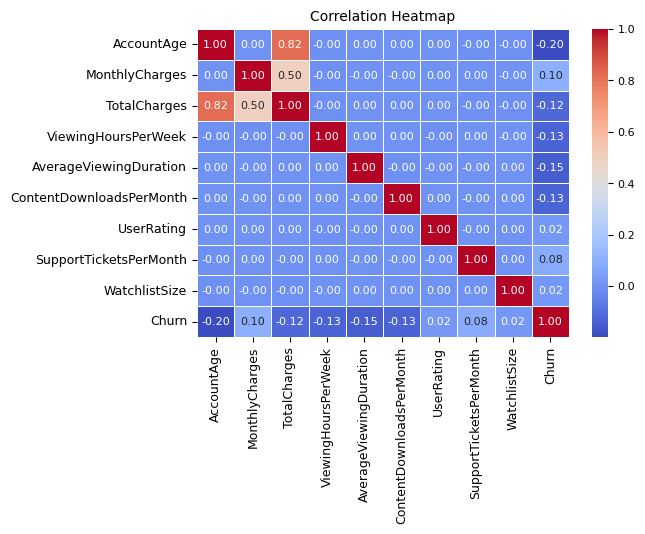

In [15]:
# Visually
plt.figure(figsize=(6,4))
ax = sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 8}, cbar_kws={})

plt.xticks(fontsize=9)  # X-axis ticks font size
plt.yticks(fontsize=9)  # Y-axis ticks font size

plt.title("Correlation Heatmap", fontsize=10)  # Title font size

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)  # This changes only the font size of the tick labels on the color bar

plt.show()


In [16]:
# Variance Inflation Factor (VIF) - chasing multicollinearity 
#num_cols.remove('TotalCharges')
num_cols_corr
X = train_df[num_cols_corr]
X_with_const = add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
print(vif_data)

                     Feature        VIF
0                      const  60.461805
1                 AccountAge   9.348258
2             MonthlyCharges   4.090599
3               TotalCharges  12.428072
4        ViewingHoursPerWeek   1.018569
5     AverageViewingDuration   1.024339
6   ContentDownloadsPerMonth   1.018986
7                 UserRating   1.000559
8     SupportTicketsPerMonth   1.007891
9              WatchlistSize   1.000548
10                     Churn   1.127317


#### 2. Testing data

In [17]:
# Overall view
print("Testing Data Info:")
print(test_df.info())
print(55*'-')
print("Unique values:")
print(test_df.nunique())

Testing Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104480 entries, 0 to 104479
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   AccountAge                104480 non-null  int64  
 1   MonthlyCharges            104480 non-null  float64
 2   TotalCharges              104480 non-null  float64
 3   SubscriptionType          104480 non-null  object 
 4   PaymentMethod             104480 non-null  object 
 5   PaperlessBilling          104480 non-null  object 
 6   ContentType               104480 non-null  object 
 7   MultiDeviceAccess         104480 non-null  object 
 8   DeviceRegistered          104480 non-null  object 
 9   ViewingHoursPerWeek       104480 non-null  float64
 10  AverageViewingDuration    104480 non-null  float64
 11  ContentDownloadsPerMonth  104480 non-null  int64  
 12  GenrePreference           104480 non-null  object 
 13  UserRating               

In [18]:
# Let's see the statistics
test_df.describe()

,AccountAge,MonthlyCharges,TotalCharges,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,UserRating,SupportTicketsPerMonth,WatchlistSize
count,104480.000000,104480.000000,104480.000000,104480.000000,104480.000000,104480.000000,104480.000000,104480.000000,104480.000000
mean,60.064692,12.474347,748.167669,20.489914,92.646128,24.450900,3.000958,4.507705,12.040400
std,34.285025,4.331734,520.782838,11.243173,50.631406,14.451309,1.154689,2.876700,7.204115
min,1.000000,4.990051,5.019144,1.000528,5.000985,0.000000,1.000016,0.000000,0.000000
25%,30.000000,8.725621,328.961543,10.767551,48.554662,12.000000,2.000577,2.000000,6.000000
50%,60.000000,12.453073,649.385029,20.472305,92.533168,25.000000,2.997293,5.000000,12.000000
75%,90.000000,16.214247,1081.266991,30.196107,136.622615,37.000000,4.000671,7.000000,18.000000
max,119.000000,19.989797,2376.235183,39.999296,179.999785,49.000000,4.999930,9.000000,24.000000


In [19]:
# Missing Values - to be sure
test_df.isnull().sum()   

AccountAge                  0
MonthlyCharges              0
TotalCharges                0
SubscriptionType            0
PaymentMethod               0
PaperlessBilling            0
ContentType                 0
MultiDeviceAccess           0
DeviceRegistered            0
ViewingHoursPerWeek         0
AverageViewingDuration      0
ContentDownloadsPerMonth    0
GenrePreference             0
UserRating                  0
SupportTicketsPerMonth      0
Gender                      0
WatchlistSize               0
ParentalControl             0
SubtitlesEnabled            0
CustomerID                  0
dtype: int64

In [20]:
# Duplicates
test_df.duplicated().sum()

0

In [21]:
# Outliers
Q1 = test_df[num_cols].quantile(0.25)
Q3 = test_df[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = (test_df[num_cols] < (Q1 - 1.5 * IQR)) | (test_df[num_cols] > (Q3 + 1.5 * IQR))
outliers
outlier_number = outliers.sum()
outlier_ratio =  outliers.sum() / 104480 * 100
outlier_number, outlier_ratio

(AccountAge                    0
 MonthlyCharges                0
 TotalCharges                383
 ViewingHoursPerWeek           0
 AverageViewingDuration        0
 ContentDownloadsPerMonth      0
 UserRating                    0
 SupportTicketsPerMonth        0
 WatchlistSize                 0
 dtype: int64,
 AccountAge                  0.000000
 MonthlyCharges              0.000000
 TotalCharges                0.366577
 ViewingHoursPerWeek         0.000000
 AverageViewingDuration      0.000000
 ContentDownloadsPerMonth    0.000000
 UserRating                  0.000000
 SupportTicketsPerMonth      0.000000
 WatchlistSize               0.000000
 dtype: float64)

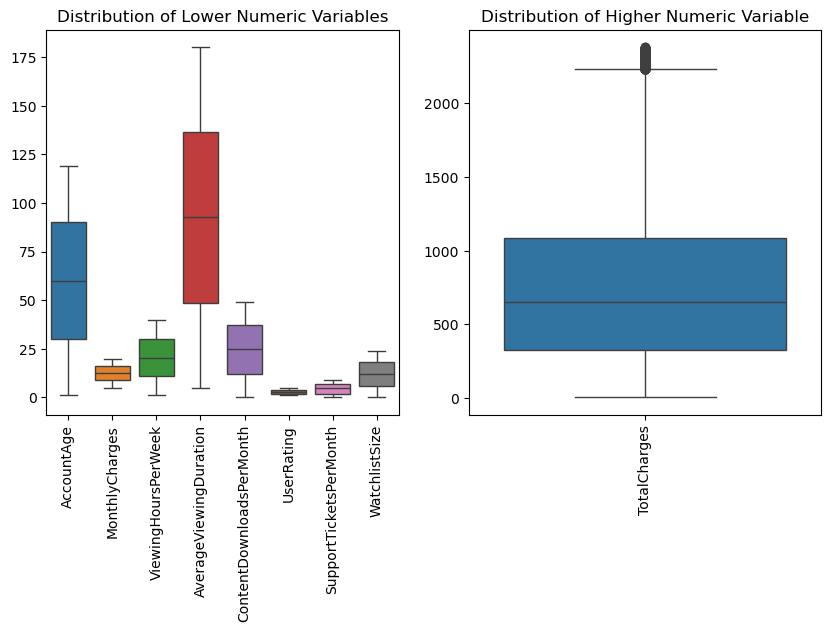

In [22]:
# Let's see the outliers
fig, axes = plt.subplots(1, 2, figsize=(10,5))

data_t = test_df[['AccountAge', 'MonthlyCharges', 'ViewingHoursPerWeek', 'AverageViewingDuration', 'ContentDownloadsPerMonth', 'UserRating', 'SupportTicketsPerMonth',  'WatchlistSize']] 
data_t1 = test_df[['TotalCharges']]
sns.boxplot(data=data_t, ax=axes[0])
axes[0].set_title("Distribution of Lower Numeric Variables")
axes[0].tick_params(axis='x', rotation=90)

sns.boxplot(data=data1, ax=axes[1])
axes[1].set_title("Distribution of Higher Numeric Variable")
axes[1].tick_params(axis='x', rotation=90)
plt.show()

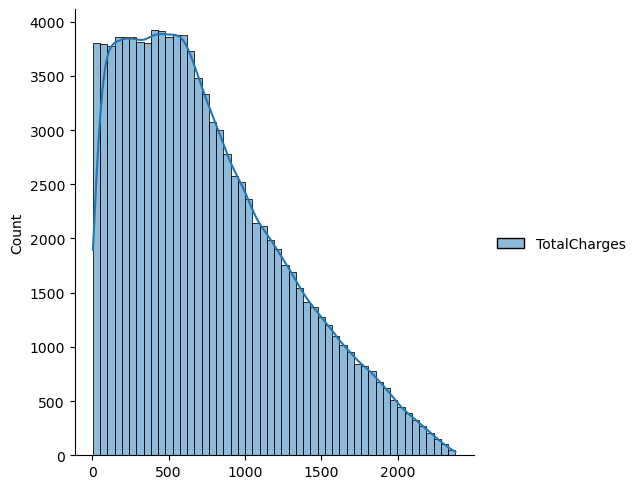

In [23]:
# More closely
sns.displot(data_t1, bins=50, kde=True)
plt.show()

## Feature Engineering

In [24]:
#Introducing 3 new features (capturing percieved value, depth of interest and dissatisfaction)
train_df['EngagementPerDollar'] = train_df['ViewingHoursPerWeek'] / train_df['MonthlyCharges'].replace(0, 1)
train_df['ContentEngagementDepth'] = train_df['AverageViewingDuration'] * train_df['ViewingHoursPerWeek']
train_df['LowRatedButHighUse'] = ((train_df['UserRating'] <= 3) & (train_df['ViewingHoursPerWeek'] > 10)).astype(int)

In [25]:
# Before encoding or scaling
test_df['EngagementPerDollar'] = test_df['ViewingHoursPerWeek'] / test_df['MonthlyCharges'].replace(0, 1)
test_df['ContentEngagementDepth'] = test_df['AverageViewingDuration'] * test_df['ViewingHoursPerWeek']
test_df['LowRatedButHighUse'] = ((test_df['UserRating'] <= 3) & (test_df['ViewingHoursPerWeek'] > 10)).astype(int)

## Data Preprocessing

In [26]:
# Cleaning the 'Gender' and other columns in both datasets
cols_to_clean = [
    'Gender', 'SubscriptionType', 'PaymentMethod', 'PaperlessBilling', 'ContentType', 
    'MultiDeviceAccess', 'DeviceRegistered', 'GenrePreference', 'ParentalControl', 
    'SubtitlesEnabled', 'CustomerID']

# Remove leading/trailing spaces 
train_df[cols_to_clean] = train_df[cols_to_clean].apply(lambda x: x.str.strip())
test_df[cols_to_clean] = test_df[cols_to_clean].apply(lambda x: x.str.strip())

# Check unique values to make sure both datasets are aligned
for column in cols_to_clean:
    print(f"{column}: {train_df[column].unique()}")
    print(f"{column}: {test_df[column].unique()}")
    print(32*'-')

Gender: ['Male' 'Female']
Gender: ['Male' 'Female']
--------------------------------
SubscriptionType: ['Premium' 'Basic' 'Standard']
SubscriptionType: ['Premium' 'Basic' 'Standard']
--------------------------------
PaymentMethod: ['Mailed check' 'Credit card' 'Electronic check' 'Bank transfer']
PaymentMethod: ['Mailed check' 'Electronic check' 'Bank transfer' 'Credit card']
--------------------------------
PaperlessBilling: ['No' 'Yes']
PaperlessBilling: ['No' 'Yes']
--------------------------------
ContentType: ['Both' 'Movies' 'TV Shows']
ContentType: ['TV Shows' 'Both' 'Movies']
--------------------------------
MultiDeviceAccess: ['No' 'Yes']
MultiDeviceAccess: ['No' 'Yes']
--------------------------------
DeviceRegistered: ['Mobile' 'Tablet' 'Computer' 'TV']
DeviceRegistered: ['TV' 'Computer' 'Tablet' 'Mobile']
--------------------------------
GenrePreference: ['Sci-Fi' 'Action' 'Fantasy' 'Drama' 'Comedy']
GenrePreference: ['Comedy' 'Action' 'Sci-Fi' 'Drama' 'Fantasy']
-----------

### Saving Raw Data


In [27]:
# Saving raw data
train_df_start = train_df.copy()
test_df_start = test_df.copy()

### Encoding and Scaling

*First let's create X and y.*

In [28]:
# Split target and features
target_col = "Churn"
unique_identifier = "CustomerID"

y = train_df[target_col]
X = train_df.drop(columns=[target_col, unique_identifier])

In [29]:
# ---> Repeating the same for the Test dataset¶
unique_identifier = "CustomerID"
X_test = test_df.drop(columns=[unique_identifier])

In [30]:
print(X.nunique())
print("--------------")
print(X_test.nunique())

AccountAge                     119
MonthlyCharges              243787
TotalCharges                243787
SubscriptionType                 3
PaymentMethod                    4
PaperlessBilling                 2
ContentType                      3
MultiDeviceAccess                2
DeviceRegistered                 4
ViewingHoursPerWeek         243787
AverageViewingDuration      243787
ContentDownloadsPerMonth        50
GenrePreference                  5
UserRating                  243787
SupportTicketsPerMonth          10
Gender                           2
WatchlistSize                   25
ParentalControl                  2
SubtitlesEnabled                 2
EngagementPerDollar         243787
ContentEngagementDepth      243787
LowRatedButHighUse               2
dtype: int64
--------------
AccountAge                     119
MonthlyCharges              104480
TotalCharges                104480
SubscriptionType                 3
PaymentMethod                    4
PaperlessBilling           

*Then let's identify the different column types (numeric, categorical, boolean)*

In [31]:
# Identify column types

num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
bool_cols = X.select_dtypes(include='bool').columns

print('Numeric columns:', num_cols)
print('--------')
print('Categorical columns:', cat_cols)
print('--------')
print('Boolean columns:', bool_cols)

Numeric columns: ['AccountAge', 'MonthlyCharges', 'TotalCharges', 'ViewingHoursPerWeek', 'AverageViewingDuration', 'ContentDownloadsPerMonth', 'UserRating', 'SupportTicketsPerMonth', 'WatchlistSize', 'EngagementPerDollar', 'ContentEngagementDepth', 'LowRatedButHighUse']
--------
Categorical columns: ['SubscriptionType', 'PaymentMethod', 'PaperlessBilling', 'ContentType', 'MultiDeviceAccess', 'DeviceRegistered', 'GenrePreference', 'Gender', 'ParentalControl', 'SubtitlesEnabled']
--------
Boolean columns: Index([], dtype='object')


***For tree models** let's apply label encoding to categorical columns. This transforms categorical values into integers by assigning a unique number to each category.*

In [32]:
# Store a separate encoder for each categorical column
label_encoders = {}

X_le = X.copy()
X_test_le = X_test.copy()

for column in cat_cols:
    le = LabelEncoder()
    X_le[column] = le.fit_transform(X_le[column])
    X_test_le[column] = le.transform(X_test_le[column])
    label_encoders[column] = le  # save encoder 

***For linear Models, SVM, etc.** let's apply one-hot-encoding to categorical columns.*

In [33]:
# Applying one-hot encoding to categorical columns (for Linear Models, SVM, etc.)

X_ohe = pd.get_dummies(X, columns=cat_cols, drop_first=True)
X_test_ohe = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

In [34]:
# Identify and convert boolean columns to integers
bool_cols = X_ohe.select_dtypes(include='bool').columns
print('Boolean columns:', bool_cols)

X_ohe[bool_cols] = X_ohe[bool_cols].astype(int)
X_test_ohe[bool_cols] = X_test_ohe[bool_cols].astype(int)

Boolean columns: Index(['SubscriptionType_Premium', 'SubscriptionType_Standard',
       'PaymentMethod_Credit card', 'PaymentMethod_Electronic check',
       'PaymentMethod_Mailed check', 'PaperlessBilling_Yes',
       'ContentType_Movies', 'ContentType_TV Shows', 'MultiDeviceAccess_Yes',
       'DeviceRegistered_Mobile', 'DeviceRegistered_TV',
       'DeviceRegistered_Tablet', 'GenrePreference_Comedy',
       'GenrePreference_Drama', 'GenrePreference_Fantasy',
       'GenrePreference_Sci-Fi', 'Gender_Male', 'ParentalControl_Yes',
       'SubtitlesEnabled_Yes'],
      dtype='object')


In [35]:
# Standard scaling (for SVM, KNN, LR, NN, KMeans)
scaler = StandardScaler()
X_ohe_scaled = pd.DataFrame(scaler.fit_transform(X_ohe), columns=X_ohe.columns)
X_test_ohe_scaled = pd.DataFrame(scaler.transform(X_test_ohe), columns=X_test_ohe.columns)

### Correlation Check

*For numerical and encoded categorical columns*

In [36]:
# Compute absolute correlation matrix
corr_matrix = X_ohe_scaled.corr().abs()

# Upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Extract highly correlated pairs (e.g., > 0.95)
high_corr = upper.stack().reset_index()
high_corr.columns = ['Feature_1', 'Feature_2', 'Correlation']
high_corr = high_corr[high_corr['Correlation'] > 0.95].sort_values(by='Correlation', ascending=False)

In [37]:
display(high_corr)

,Feature_1,Feature_2,Correlation


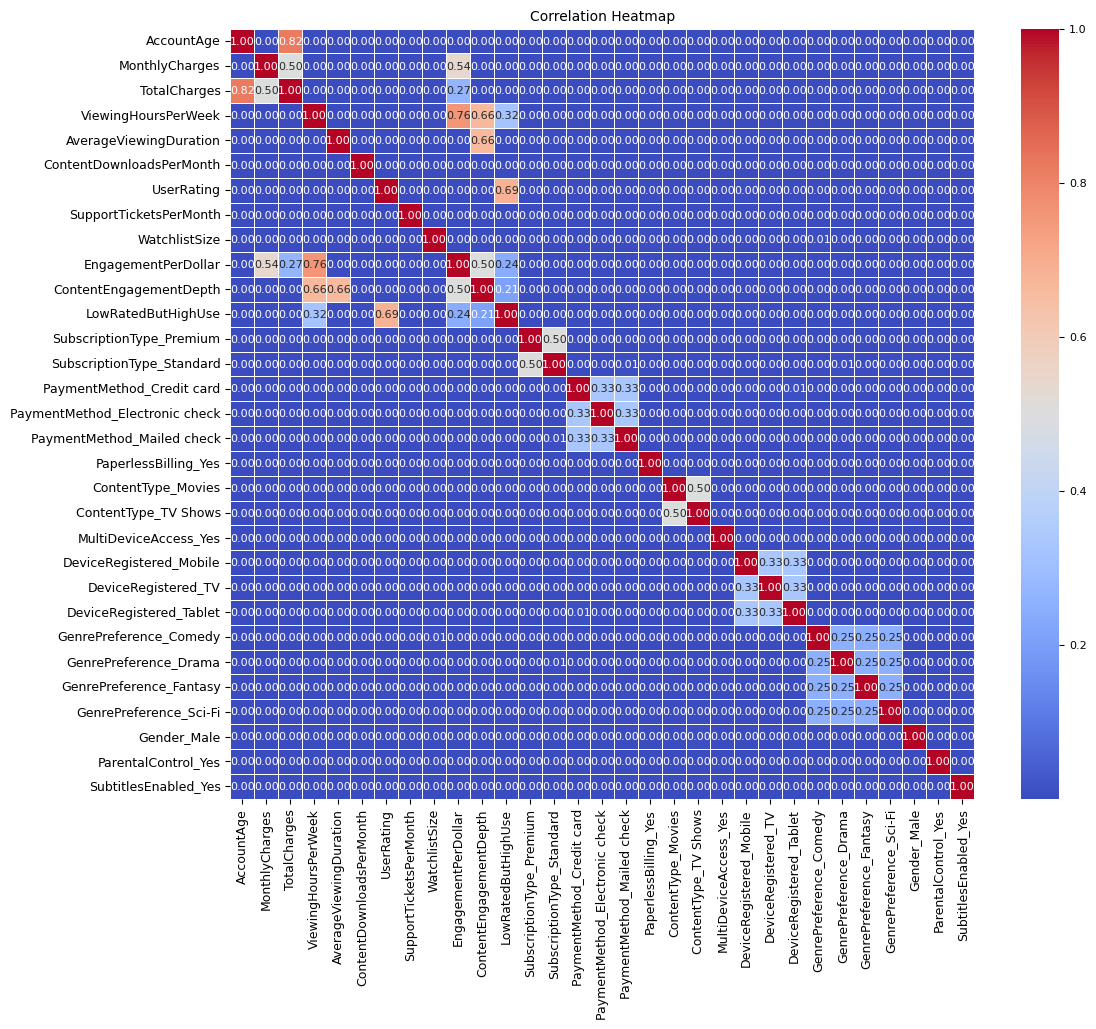

In [38]:
# Visually
plt.figure(figsize=(12,10))
ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 8}, cbar_kws={})

plt.xticks(fontsize=9)  # X-axis ticks font size
plt.yticks(fontsize=9)  # Y-axis ticks font size

plt.title("Correlation Heatmap", fontsize=10)  # Title font size

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)  # This changes only the font size of the tick labels on the color bar

plt.show()

*Variance Inflation Factor (VIF) - still chasing multicollinearity*

In [39]:
# Add constant for intercept
X_vif = add_constant(X_ohe_scaled)

# Calculate VIF
vif_data = [
    (X_vif.columns[i], variance_inflation_factor(X_vif.values, i))
    for i in range(X_vif.shape[1])
]

vif_df = pd.DataFrame(vif_data, columns=["Feature", "VIF"]).sort_values(by="VIF", ascending=False)

In [40]:
# Filter only problematic features (>10 to drop)
display(vif_df[vif_df["VIF"] > 5])

,Feature,VIF
3,TotalCharges,12.416968
1,AccountAge,9.335084
4,ViewingHoursPerWeek,8.745613
11,ContentEngagementDepth,7.671166
10,EngagementPerDollar,7.283335
2,MonthlyCharges,6.165349


In [41]:
# Dropping problematic features
X_ohe_scaled_reduced = X_ohe_scaled.drop(columns=['TotalCharges'])
X_test_ohe_scaled_reduced = X_test_ohe_scaled.drop(columns=['TotalCharges'])

In [42]:
# Add constant
X_vif = add_constant(X_ohe_scaled_reduced)

# Recalculate VIF
vif_data = [
    (X_vif.columns[i], variance_inflation_factor(X_vif.values, i))
    for i in range(X_vif.shape[1])
]

vif_df = pd.DataFrame(vif_data, columns=["Feature", "VIF"])
vif_df = vif_df[vif_df["Feature"] != "const"].sort_values(by="VIF", ascending=False)

In [43]:
display(vif_df)

,Feature,VIF
3,ViewingHoursPerWeek,8.745613
10,ContentEngagementDepth,7.671162
9,EngagementPerDollar,7.283327
4,AverageViewingDuration,4.326279
2,MonthlyCharges,3.094961
11,LowRatedButHighUse,2.325460
6,UserRating,2.091962
24,GenrePreference_Comedy,1.603734
26,GenrePreference_Fantasy,1.602844
25,GenrePreference_Drama,1.601149


### Baseline Logistic Regression Model & Feature Importance

In [44]:
# Train Logistic Regression on the imbalanced dataset (without SMOTE)
lr_feature = LogisticRegression(C=1.0, penalty='l2', solver='lbfgs', class_weight='balanced', max_iter=500)
lr_feature.fit(X_ohe_scaled_reduced, y)

LogisticRegression(class_weight='balanced', max_iter=500)

In [45]:
# Looking for weak features to drop
feature_importance = pd.DataFrame({"Feature": X_ohe_scaled_reduced.columns, "Importance": np.abs(lr_feature.coef_[0])})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)
feature_importance

,Feature,Importance
0,AccountAge,0.597643
3,AverageViewingDuration,0.415163
4,ContentDownloadsPerMonth,0.392568
2,ViewingHoursPerWeek,0.355480
1,MonthlyCharges,0.301815
6,SupportTicketsPerMonth,0.251917
11,SubscriptionType_Premium,0.126779
23,GenrePreference_Comedy,0.085766
26,GenrePreference_Sci-Fi,0.081739
7,WatchlistSize,0.062174


In [46]:
#Summary of usable versions of the dataset
#For linear models, SVMs, KNN, NN, KMeans
X_lin = X_ohe_scaled_reduced
X_lin_test = X_test_ohe_scaled_reduced
# For Tree models
X_tree = X_le
X_tree_test = X_test_le 

### Logistic Regression

In [47]:
# Handling Churn imbalance
lr_pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto')),  # SMOTE applied only on training folds
    ('lr', LogisticRegression(class_weight='balanced', max_iter=500))  # Added max_iter for convergence
])

In [48]:
# Hyperparameter grid
lr_params = {
    'lr__C': [0.01, 0.1, 1, 10, 100],
    'lr__penalty':['l2'],
    'lr__solver': ['lbfgs', 'saga']
}   

In [49]:
# Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=4)

In [50]:
# Training with Grid Search - without weak features (with ROC AUC scoring)
lr_grid = GridSearchCV(lr_pipeline, lr_params, cv=cv_strategy, scoring='roc_auc', n_jobs=-1, verbose=2)
lr_grid.fit(X_lin, y)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


  File "C:\Users\veszt\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE()),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=500))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.01, 0.1, 1, 10, 100],
                         'lr__penalty': ['l2'],
                         'lr__solver': ['lbfgs', 'saga']},
             scoring='roc_auc', verbose=2)

In [51]:
# Best lr model and its predicted probabilities
lr_best = lr_grid.best_estimator_
lr_prob = lr_best.predict_proba(X_lin_test)[:,1]

print(f'Best estimator: {lr_best}'),
print(f'Probability: {lr_prob}')

Best estimator: Pipeline(steps=[('smote', SMOTE()),
                ('lr',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=500, solver='saga'))])
Probability: [0.31492668 0.1302743  0.78233979 ... 0.31424194 0.63581745 0.05518959]


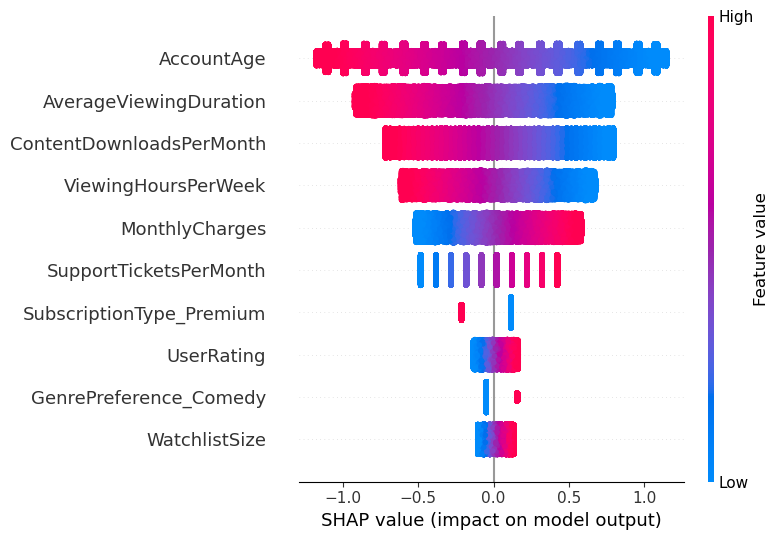

In [57]:
# Extract trained model from grid search
lr_best_model = lr_best.named_steps['lr']

# Build SHAP explainer from the trained logistic regression model
explainer = shap.Explainer(lr_best_model, X_lin)

# SHAP values on test set
shap_values = explainer(X_lin_test)

# Plot
shap.summary_plot(shap_values, max_display=10)
#shap.plots.beeswarm(shap_values, max_display=12)

### Random Forest

In [58]:
# Handling Churn imbalance
rf_pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto')),  # SMOTE applied only on training folds
    ('rf', RandomForestClassifier(class_weight='balanced', random_state=42))  # Added max_iter for convergence
])

In [59]:
# Hyperparameter grid

# rf_params = {'rf__n_estimators': [100, 200],
#    'rf__criterion': ['gini', 'entropy'],
#     'rf__max_depth': [10, 20],
#     'rf__max_features': ['log2', 'sqrt', 'auto'],
#     'rf__min_samples_leaf': [1, 2, 4],
#     'rf__min_samples_split': [2, 5]}

rf_params = {'rf__n_estimators': [100],
    'rf__criterion': ['gini'],
     'rf__max_depth': [10],
     'rf__max_features': ['log2'],
     'rf__min_samples_leaf': [1],
     'rf__min_samples_split': [2]}


In [60]:
# Cross-validation strategy is the same as for lr
cv_strategy = StratifiedKFold(n_splits=4)

In [61]:
# Training with Grid Search
rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=cv_strategy, scoring='roc_auc',n_jobs=-1, verbose=0)
rf_grid.fit(X_tree, y)

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE()),
                                       ('rf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['gini'], 'rf__max_depth': [10],
                         'rf__max_features': ['log2'],
                         'rf__min_samples_leaf': [1],
                         'rf__min_samples_split': [2],
                         'rf__n_estimators': [100]},
             scoring='roc_auc')

In [62]:
# Best rf model and its predicted probabilities
rf_best = rf_grid.best_estimator_
rf_prob = rf_best.predict_proba(X_tree_test)[:,1]

print(f'Best estimator: {rf_best}'),
print(f'Probability: {rf_prob}')

Best estimator: Pipeline(steps=[('smote', SMOTE()),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        max_features='log2',
                                        random_state=42))])
Probability: [0.41246217 0.10598632 0.48632105 ... 0.41089832 0.46136656 0.32166618]


### LightGBM

In [63]:
#Handling Churn imbalance
lgbm_pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),  # SMOTE applied only on training folds
    ('lgbm', LGBMClassifier(objective='binary', random_state=42))  
])

In [64]:
lgbm_params = {
    'lgbm__n_estimators': [100, 200],
    'lgbm__max_depth': [6, 10],
    'lgbm__learning_rate': [0.01, 0.1],
    'lgbm__num_leaves': [31, 64],
    'lgbm__verbosity': [-1]
}

In [65]:
#Cross-validation strategy 
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [66]:
#Training with Grid Search
lgbm_grid = GridSearchCV(lgbm_pipeline, lgbm_params, cv=cv_strategy, scoring='roc_auc', n_jobs=1, verbose=0)
lgbm_grid.fit(X_tree, y, lgbm__categorical_feature=cat_cols)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('lgbm',
                                        LGBMClassifier(objective='binary',
                                                       random_state=42))]),
             n_jobs=1,
             param_grid={'lgbm__learning_rate': [0.01, 0.1],
                         'lgbm__max_depth': [6, 10],
                         'lgbm__n_estimators': [100, 200],
                         'lgbm__num_leaves': [31, 64],
                         'lgbm__verbosity': [-1]},
             scoring='roc_auc')

In [67]:
# Best svm model and its predicted probabilities
lgbm_best = lgbm_grid.best_estimator_
lgbm_prob = lgbm_best.predict_proba(X_tree_test)[:,1]

print(f'Best estimator: {lgbm_best}'),
print(f'Probability: {lgbm_prob}')

Best estimator: Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('lgbm',
                 LGBMClassifier(max_depth=10, n_estimators=200,
                                objective='binary', random_state=42,
                                verbosity=-1))])
Probability: [0.31872712 0.07309264 0.39090863 ... 0.31411597 0.15744461 0.07235428]


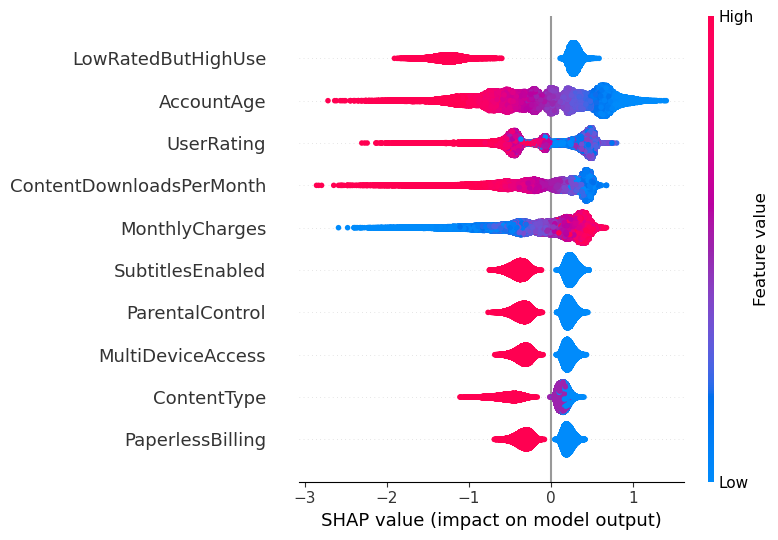

In [68]:
# Extract trained model from grid search
#best_gbm_model = lr_grid.best_estimator_.named_steps['lr']
lgbm_best_model = lgbm_best.named_steps['lgbm']

# Build SHAP explainer from the trained logistic regression model
explainer = shap.TreeExplainer(lgbm_best_model)

# SHAP values on test set
shap_values = explainer(X_tree_test)

# Plot
shap.summary_plot(shap_values, max_display=10)
#shap.plots.beeswarm(shap_values, max_display=12)

#### LGBM with Optuna

In [69]:
# Step 1: Define pipeline
lgbm_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('lgbm', LGBMClassifier(objective='binary', random_state=42))
])

# Step 2: Define Optuna search space
lgbm_param_space = {
    'lgbm__n_estimators': IntDistribution(100, 500),
    'lgbm__learning_rate': FloatDistribution(0.01, 0.1, log=True),
    'lgbm__max_depth': IntDistribution(4, 10),
    'lgbm__num_leaves': IntDistribution(16, 128),
    'lgbm__min_child_samples': IntDistribution(10, 30),
    'lgbm__subsample': FloatDistribution(0.7, 1.0),
    'lgbm__colsample_bytree': FloatDistribution(0.7, 1.0),
    'lgbm__reg_alpha': FloatDistribution(0.0, 0.5),
    'lgbm__reg_lambda': FloatDistribution(0.0, 0.5),
    'lgbm__verbosity': CategoricalDistribution([-1])
}

# Step 3: Cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Step 4: Set up OptunaSearchCV
optuna_search = OptunaSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=lgbm_param_space,
    cv=cv_strategy,
    scoring='roc_auc',
    n_trials=50,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

In [70]:
# Step 5: Fit Optuna tuning
optuna_search.fit(X_tree, y, lgbm__categorical_feature=cat_cols)

OptunaSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
               estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                         ('lgbm',
                                          LGBMClassifier(objective='binary',
                                                         random_state=42))]),
               n_jobs=-1, n_trials=50,
               param_distributions={'lgbm__colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.7, step=None),
                                    'lgbm__learning_rate': FloatDis...
                                    'lgbm__num_leaves': IntDistribution(high=128, log=False, low=16, step=1),
                                    'lgbm__reg_alpha': FloatDistribution(high=0.5, log=False, low=0.0, step=None),
                                    'lgbm__reg_lambda': FloatDistribution(high=0.5, log=False, low=0.0, step=None),
                                    'lgbm__subsample': FloatDistribution(high=1.0, log=False, low=0.7, step=None),
                                    'lgbm__verbosity': CategoricalDistribution(choices=(-1,))},
               random_state=42, scoring='roc_auc')

In [71]:
# Best estimator
lgbm_best_opt = optuna_search.best_estimator_

print("Best params:", optuna_search.best_params_)
print("Best CV ROC-AUC:", optuna_search.best_score_)

# Predict on test
lgbm_prob_opt = lgbm_best_opt.predict_proba(X_tree_test)[:, 1]

print(f'Best estimator: {lgbm_best_opt}'),
print(f'Probability: {lgbm_prob_opt}')

Best params: {'lgbm__n_estimators': 390, 'lgbm__learning_rate': 0.05945323525122946, 'lgbm__max_depth': 10, 'lgbm__num_leaves': 41, 'lgbm__min_child_samples': 14, 'lgbm__subsample': 0.8171409474918117, 'lgbm__colsample_bytree': 0.8071353498343274, 'lgbm__reg_alpha': 0.02216062106824268, 'lgbm__reg_lambda': 0.499170588603461, 'lgbm__verbosity': -1}
Best CV ROC-AUC: 0.6964579296726267
Best estimator: Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('lgbm',
                 LGBMClassifier(colsample_bytree=0.8071353498343274,
                                learning_rate=0.05945323525122946, max_depth=10,
                                min_child_samples=14, n_estimators=390,
                                num_leaves=41, objective='binary',
                                random_state=42, reg_alpha=0.02216062106824268,
                                reg_lambda=0.499170588603461,
                                subsample=0.8171409474918117, verbosity=-1))])
Probability:

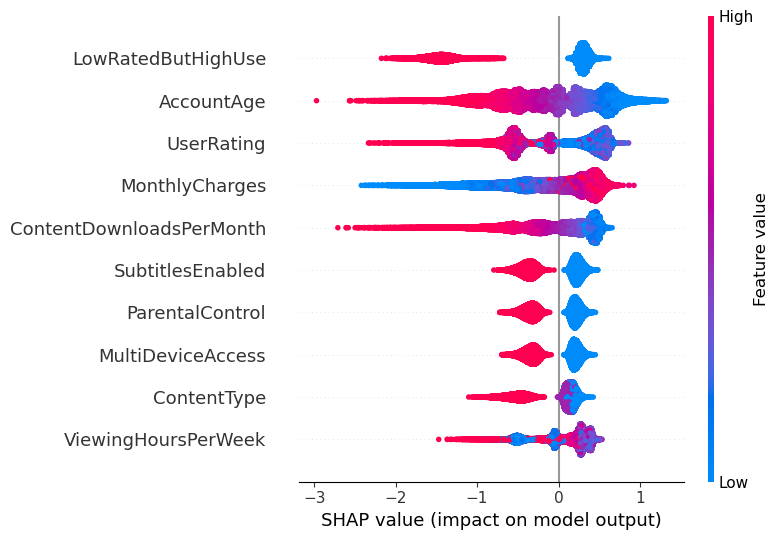

In [82]:
# Extract trained model from grid search
lgbm_best_opt_model = lgbm_best_opt.named_steps['lgbm']

# Build SHAP explainer from the trained logistic regression model
explainer = shap.TreeExplainer(lgbm_best_opt_model)

# SHAP values on test set
shap_values = explainer(X_tree_test)

# Plot
shap.summary_plot(shap_values, max_display=10)

### XGBoost

In [83]:
#Define the pipeline
xgb_pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto')),  # Apply SMOTE for balancing
    ('xgb', XGBClassifier(eval_metric='logloss', use_label_encoder=False))  # XGBoost model
])

In [84]:
#Hyperparameter grid for tuning XGBoost
xgb_params = {'xgb__n_estimators': [50, 100],  # Number of boosting rounds
    'xgb__learning_rate': [0.05, 0.1],  # Step size for each boosting round
    'xgb__max_depth': [3, 6],  # Maximum depth of each tree
    'xgb__subsample': [0.8],  # Proportion of samples used in each boosting round
    'xgb__colsample_bytree': [0.8],  # Fraction of features used per tree
    'xgb__scale_pos_weight': [4.5],  # Balance the positive class weight for imbalanced data 
}

In [85]:
#3-fold cross-validation for quicker evaluation
cv_strategy = StratifiedKFold(n_splits=3)

In [86]:
# Training with Grid Search
xgb_grid = GridSearchCV(xgb_pipeline, xgb_params, cv=cv_strategy, scoring='roc_auc', n_jobs=-1, verbose=0)
xgb_grid.fit(X_tree, y)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_type...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__colsample_bytree': [0.8],
                         'xgb__learning_rate': [0.05, 0.1],
                         'xgb__max_depth': [3, 6],
                         'xgb__n_estimators': [50, 100],
                         'xgb__scale_pos_weight': [4.5],
                         'xgb__subsample': [0.8]},
             scoring='roc_auc')

In [87]:
# Best xgb model and its predicted probabilities
xgb_best = xgb_grid.best_estimator_
xgb_prob = xgb_best.predict_proba(X_tree_test)[:,1]

print(f'Best estimator: {xgb_best}'),
print(f'Probability: {xgb_prob}')

Best estimator: Pipeline(steps=[('smote', SMOTE()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                       

### Comparison of Models

For classification performance on imbalanced data: ROC AUC.  
For evaluating probability calibration and penalizing confidence in wrong predictions: Log Loss.  

#### ROC-AUC and Log Loss

*Evaluate the best model with ROC-AUC and Log Loss by predicting probabilities on the training set*

In [88]:
# Logistic Regression best model

train_probs_lr = lr_best.predict_proba(X_lin)[:, 1]
train_roc_auc_lr = roc_auc_score(y, train_probs_lr)
train_log_loss_lr = log_loss(y, train_probs_lr)

print(f'ROC-AUC lr for training set: {train_roc_auc_lr}')
print(f'Log Loss lr for training set: {train_log_loss_lr}')

ROC-AUC lr for training set: 0.7501767093399986
Log Loss lr for training set: 0.5862906796385098


In [89]:
# Random forest best model
train_probs_rf = rf_best.predict_proba(X_tree)[:, 1]
train_roc_auc_rf = roc_auc_score(y, train_probs_rf)
train_log_loss_rf = log_loss(y, train_probs_rf)

print(f'ROC-AUC rf for training set: {train_roc_auc_rf}')
print(f'Log Loss rf for training set: {train_log_loss_rf}')

ROC-AUC rf for training set: 0.711005247143925
Log Loss rf for training set: 0.5281742669550039


In [90]:
# Light GBM best model
train_probs_lgbm = lgbm_best.predict_proba(X_tree)[:, 1]
train_roc_auc_lgbm = roc_auc_score(y, train_probs_lgbm)
train_log_loss_lgbm = log_loss(y, train_probs_lgbm)

print(f'ROC-AUC lgbm for training set: {train_roc_auc_lgbm}')
print(f'Log Loss lgbm for training set: {train_log_loss_lgbm}')

ROC-AUC lgbm for training set: 0.7188679459187791
Log Loss lgbm for training set: 0.4964315945558923


In [91]:
# Light GBM with optuna - best model
train_probs_lgbm_opt = lgbm_best_opt.predict_proba(X_tree)[:, 1]
train_roc_auc_lgbm_opt = roc_auc_score(y, train_probs_lgbm_opt)
train_log_loss_lgbm_opt = log_loss(y, train_probs_lgbm_opt)

print(f'ROC-AUC lgbm_opt for training set: {train_roc_auc_lgbm_opt}')
print(f'Log Loss lgbm_opt for training set: {train_log_loss_lgbm_opt}')

ROC-AUC lgbm_opt for training set: 0.7285454215015219
Log Loss lgbm_opt for training set: 0.48778723587852574


In [92]:
# XGBoost best model
train_probs_xgb = xgb_best.predict_proba(X_tree)[:, 1]
train_roc_auc_xgb = roc_auc_score(y, train_probs_xgb)
train_log_loss_xgb = log_loss(y, train_probs_xgb)

print(f'ROC-AUC xgb for training set: {train_roc_auc_xgb}')
print(f'Log Loss xgb for training set: {train_log_loss_xgb}')

ROC-AUC xgb for training set: 0.7181401473287499
Log Loss xgb for training set: 0.8640743866207296


#### Cross Validation on the Training Set

In [93]:
cv_eval = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

In [94]:
# Cross-validation on the training set with lr
y_pred_lr = cross_val_predict(lr_best, X_lin, y, cv=cv_eval)  # Predicted labels using cross-validation
y_prob_lr = cross_val_predict(lr_best, X_lin, y, cv=cv_eval, method='predict_proba')[:, 1]  # Probabilities for class 1

In [95]:
# Cross-validation on the training set with rf
y_pred_rf = cross_val_predict(rf_best, X_tree, y, cv=cv_eval)  # Predicted labels using cross-validation
y_prob_rf = cross_val_predict(rf_best, X_tree, y, cv=cv_eval, method='predict_proba')[:, 1]  # Probabilities for class 1

In [96]:
# Cross-validation on the training set with lgbm
y_pred_lgbm = cross_val_predict(lgbm_best, X_tree, y, cv=cv_eval)  # Predicted labels using cross-validation
y_prob_lgbm = cross_val_predict(lgbm_best, X_tree, y, cv=cv_eval, method='predict_proba')[:, 1]  # Probabilities for class 1

In [97]:
# Cross-validation on the training set with lgbm_opt
y_pred_lgbm_opt = cross_val_predict(lgbm_best_opt, X_tree, y, cv=cv_eval)  # Predicted labels using cross-validation
y_prob_lgbm_opt = cross_val_predict(lgbm_best_opt, X_tree, y, cv=cv_eval, method='predict_proba')[:, 1]  # Probabilities for class 1

In [98]:
# Cross-validation on the training set with xgb
y_pred_xgb = cross_val_predict(xgb_best, X_tree, y, cv=cv_eval)  # Predicted labels using cross-validation
y_prob_xgb = cross_val_predict(xgb_best, X_tree, y, cv=cv_eval, method='predict_proba')[:, 1]  # Probabilities for class 1

In [99]:
# ROC-AUC Score
roc_auc_lr = roc_auc_score(y, y_prob_lr)
print(f"ROC-AUC lr: {roc_auc_lr}")

roc_auc_rf = roc_auc_score(y, y_prob_rf)
print(f"ROC-AUC rf: {roc_auc_rf}")

roc_auc_lgbm = roc_auc_score(y, y_prob_lgbm)
print(f"ROC-AUC lgbm: {roc_auc_lgbm}")

roc_auc_lgbm_opt = roc_auc_score(y, y_prob_lgbm_opt)
print(f"ROC-AUC lgbm_opt: {roc_auc_lgbm_opt}")

roc_auc_xgb = roc_auc_score(y, y_prob_xgb)
print(f"ROC-AUC xgb: {roc_auc_xgb}")

ROC-AUC lr: 0.7498745388354484
ROC-AUC rf: 0.6803458574267538
ROC-AUC lgbm: 0.6959745760427204
ROC-AUC lgbm_opt: 0.6966145610987159
ROC-AUC xgb: 0.6937878674625744


In [100]:
# Log Loss
logloss_lr = log_loss(y, y_prob_lr)
print(f"Log Loss lr: {logloss_lr}")

logloss_rf = log_loss(y, y_prob_rf)
print(f"Log Loss rf: {logloss_rf}")

logloss_lgbm = log_loss(y, y_prob_lgbm)
print(f"Log Loss lgbm: {logloss_lgbm}")

logloss_lgbm_opt = log_loss(y, y_prob_lgbm_opt)
print(f"Log Loss lgbm_opt: {logloss_lgbm_opt}")

logloss_xgb = log_loss(y, y_prob_xgb)
print(f"Log Loss xgb: {logloss_xgb}")

Log Loss lr: 0.5864591038896032
Log Loss rf: 0.5413956738632094
Log Loss lgbm: 0.5130849479450975
Log Loss lgbm_opt: 0.5116875298598095
Log Loss xgb: 0.8769138771555641


In [101]:
# Precision
precision_lr = precision_score(y, y_pred_lr)
precision_rf = precision_score(y, y_pred_rf)
precision_lgbm = precision_score(y, y_pred_lgbm)
precision_lgbm_opt = precision_score(y, y_pred_lgbm_opt)
precision_xgb = precision_score(y, y_pred_xgb)

print(f"Precision lr: {precision_lr:.4f}")
print(f"Precision rf: {precision_rf:.4f}")
print(f"Precision lgbm: {precision_lgbm:.4f}")
print(f"Precision lgbm_opt: {precision_lgbm_opt:.4f}")
print(f"Precision xgb: {precision_xgb:.4f}")

Precision lr: 0.3243
Precision rf: 0.3102
Precision lgbm: 0.3328
Precision lgbm_opt: 0.3348
Precision xgb: 0.2477


In [102]:
# Recall
recall_lr = recall_score(y, y_pred_lr)
recall_rf = recall_score(y, y_pred_rf)
recall_lgbm = recall_score(y, y_pred_lgbm)
recall_lgbm_opt = recall_score(y, y_pred_lgbm_opt)
recall_xgb = precision_score(y, y_pred_xgb)

print(f"Recall lr:    {recall_lr:.4f}")
print(f"Recall rf:    {recall_rf:.4f}")
print(f"Recall lgbm:    {recall_lgbm:.4f}")
print(f"Recall lgbm_opt:    {recall_lgbm_opt:.4f}")
print(f"Recall xgb:    {recall_xgb:.4f}")

Recall lr:    0.6813
Recall rf:    0.3936
Recall lgbm:    0.3582
Recall lgbm_opt:    0.3564
Recall xgb:    0.2477


In [103]:
# F1
f1_lr = f1_score(y, y_pred_lr)
f1_rf = f1_score(y, y_pred_rf)
f1_lgbm = f1_score(y, y_pred_lgbm)
f1_lgbm_opt = f1_score(y, y_pred_lgbm_opt)
f1_xgb = f1_score(y, y_pred_xgb)

print(f"F1 Score lr:  {f1_lr:.4f}")
print(f"F1 Score rf:  {f1_rf:.4f}")
print(f"F1 Score lgbm:  {f1_lgbm:.4f}")
print(f"F1 Score lgbm_opt:  {f1_lgbm_opt:.4f}")
print(f"F1 Score xgb:  {f1_xgb:.4f}")

F1 Score lr:  0.4394
F1 Score rf:  0.3469
F1 Score lgbm:  0.3450
F1 Score lgbm_opt:  0.3453
F1 Score xgb:  0.3803


##### *Since the goal is to minimize false churn predictions (False Positives), we should prioritize Precision over Recall (High precision means few false positives)*

### Model Evaluation Summary (Focus: Reduce False Positives → Maximize Precision)


| Model             | Train ROC-AUC | Train Log Loss | CV ROC-AUC | CV Log Loss | Precision | Recall  | F1 Score |
|------------------ |---------------|----------------|-------------|------------|-----------|---------|----------|
| *Metric Goal →*   | ↑ Higher      | ↓ Lower        | ↑ Higher    | ↓ Lower    |**↑ Higher**|   (↑)  |(↑ Higher)|
| **LogReg**        | 0.7502        | 0.5865         | 0.7498      | 0.5869     | 0.3246    | 0.6823  | 0.4399   |
| **RandomForest**  | 0.7117        | 0.5281         | 0.6801      | 0.5416     | 0.3103    | 0.3924  | 0.3465   |
| **LightGBM**      | 0.7189        | 0.4964         | 0.6960      | 0.5131     | 0.3328    | 0.3582  | 0.3450   |
| **LGBM (Optuna)** | **0.7247**    | **0.4922**     | **0.6961**  | **0.5126** | **0.3325**| 0.3618  | 0.3465   |
| **XGBoost**       | 0.7182        | 0.8635         | 0.6936      | 0.8775     | 0.2476    | 0.2476  | 0.3801   |


*The Chosen Model with the best metrics: Light GBM with Optuna (lgbm_opt)*  

#### Threshold calculation

In [104]:
#Compute precision-recall curve for the Chosen Model (lgbm_opt)
precisions, recalls, thresholds = precision_recall_curve(y, train_probs_lgbm_opt) 

#### Checking Threshold results

In [105]:
# Set minimum acceptable recall
min_recall = 0.15

# Track the best threshold
best_threshold = 0
best_precision = 0

for t, p, r in zip(thresholds, precisions[:-1], recalls[:-1]):
    if r >= min_recall and p > best_precision:
        best_precision = p
        best_threshold = t

print(f"Selected Threshold: {best_threshold:.4f}")
print(f"Precision: {best_precision:.4f}")

Selected Threshold: 0.6922
Precision: 0.3906


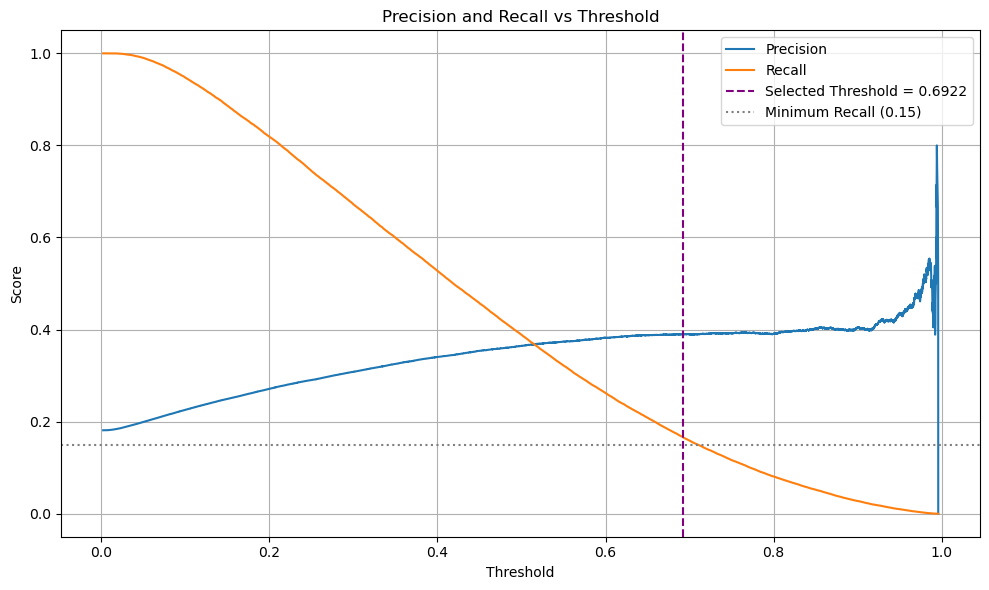

In [106]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.axvline(best_threshold, color='purple', linestyle='--', label=f'Selected Threshold = {best_threshold:.4f}')
plt.axhline(y=min_recall, color='gray', linestyle=':', label='Minimum Recall (0.15)')

plt.title("Precision and Recall vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

*We selected a conservative operating point at threshold 0.688, which yields precision of 38.7% while maintaining a minimum recall of 15%.
This ensures flagged churn risks are mostly valid, avoiding false alarms in costly retention campaigns.*

In [107]:
# Churn probabilities of the chosen model
prediction_df = pd.DataFrame({'CustomerID': test_df['CustomerID'],
                             'predicted_probability': lgbm_prob_opt 
                              })
prediction_df.head()

,CustomerID,predicted_probability
0,O1W6BHP6RM,0.292693
1,LFR4X92X8H,0.066035
2,QM5GBIYODA,0.460060
3,D9RXTK2K9F,0.021405
4,ENTCCHR1LR,0.128572



## Final Notes

This notebook builds upon a churn prediction challenge originally provided as a Coursera course, but this version has been further developed after completing the original challenge to explore additional modeling strategies, tuning methods, and evaluation techniques.  

The dataset is not included in this repository due to Coursera content policies. The notebook retains all code, visualizations, and results to showcase modeling ability. If you have access to the original dataset, the notebook will run end-to-end.

**Note:** Evaluation scores shown in this notebook were computed locally and may differ from platform-specific grading outcomes.


#### Author  
*Eszter Varga – Data Scientist*  
*GitHub: Timensider*  

*Worked through this project independently, collaborating with AI tools and documentation along the way — just as I would in a real-world workflow.*